In [2]:
import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn
import thermo
import scipy.stats as st
from sklearn.model_selection import train_test_split

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
X, y = np.load("dataset/mass_batch.npy"), np.load("dataset/res_v.npy")
initial_X, initial_y = np.load("initial_data/initial_X.npy"), np.load("initial_data/initial_y.npy")

In [301]:
# Number of arrays to randomly sample
num_arrays_to_sample = 4  # You can adjust this as needed

# Randomly choose one or more arrays from the nested array
random_arrays_indices = np.random.choice(X.shape[0], size=num_arrays_to_sample, replace=False)
random_arrays = X[random_arrays_indices]

# Print the result
print(f"Randomly chosen {num_arrays_to_sample} array(s):")
print(random_arrays)

initial_X = random_arrays

initial_y = []
for i in initial_X:
    indice = np.where(np.all(X == i, axis=1))[0][0]
    initial_y.append(y[indice])

initial_y = np.array(initial_y)

Randomly chosen 4 array(s):
[[0.064 0.668 0.268]
 [0.672 0.12  0.208]
 [0.064 0.66  0.276]
 [0.568 0.308 0.124]]


In [291]:
#going with simple experimental heuristic
initial_X = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1],
             [0.5, 0.5, 0], [0.5, 0, 0.5], [0, 0.5, 0.5]])

initial_y = []
for i in initial_X:
    indice = np.where(np.all(X == i, axis = 1))[0][0]
    initial_y.append(y[indice])

initial_y = np.array(initial_y)

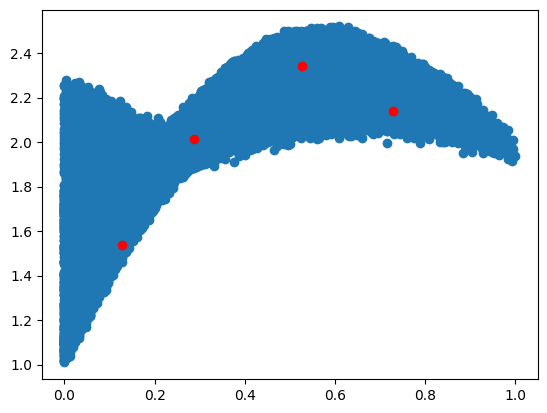

In [14]:
plt.scatter(X[:, 0], y)
plt.scatter(initial_X[:, 0], initial_y, c = 'red')

In [15]:
X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)

In [16]:
# Expected Improvement-based active learning function
def EI_learning(candidates, y_pred, pred_std):
    """Active learning function based on expected improvement
       
       This function selects a new sample from candidate pool to enrich the current training dataset.
       The sample gets selected if it has the maximum expected improvement value.
       
       Input: 
       - candidates: pool of candidates to select sample from
       - y_pred: GP predictions on candidate samples
       - pred_std: Standard deviation of the GP predictions on candidate samples
       
       Output:
       - new_sample: the selected sample with the maximum expected improvement value
       - EI: EI values of the candidate samples
    """
    
    # 1-Find the current maxima
    current_objective = y_pred[np.argmax(y_pred)]
    
    # 2-Calculate the EI values of the candidate samples
    #pred_std = pred_std.reshape(pred_std.shape[0], 1)
    EI = (current_objective-y_pred)*st.norm.cdf((current_objective-y_pred)/pred_std) \
            +pred_std*st.norm.pdf((current_objective-y_pred)/pred_std)

    # 3-Select a new sample
    new_sample = candidates[np.argmax(EI)]
    
    return new_sample, EI, np.argmax(EI)

In [17]:
n_iterations = 50
FOM_values, EI_arr, X_new_samples = [], [], []

for i in range(1, n_iterations + 1):
    print("Iteration # : {}".format(i))

    model = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=3, out_features=64),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=32),  # Additional hidden layer
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=32, out_features=16),  # Additional hidden layer
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=1),
    )

    #define the loss functions and optimizer needed
    mse_loss = nn.MSELoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
    kl_weight = 0.01

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    for step in range(250):
        pre = model(initial_X)
        mse = mse_loss(pre, initial_y.reshape(-1, 1))
        kl = kl_loss(model)
        cost = mse + kl_weight*kl
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
    print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

    model.eval()

    num_samples = 100  # should give 100 different BNN models to find array of <mean, stdev>
    predictions = torch.zeros((num_samples, X.shape[0]))

    with torch.no_grad():
        for i in range(num_samples):
            y_pred = model(X)
            predictions[i, :] = y_pred.squeeze().detach()
    
    current_objective = y_pred[np.argmax(y_pred)]
    pred_std = predictions.std(dim = 0)
    pred_mean = predictions.mean(dim = 0)

    #acquisition function results
    new_sample, EI, idx = EI_learning(X, y_pred = pred_mean, pred_std = pred_std) #gives new sample X-coords, EI, index of max(EI)
    X_new_samples.append(new_sample)
    print("New data point added : {}".format(new_sample))
    print("Corresponding FOM : {}".format(y[idx]))
    print("Target FOM : {}".format(torch.max(y).item()))
    #error_arr.append(np.abs(torch.max(y).item() - y[idx].item()))

    #y_pred_arr.append(pred_mean.detach().numpy().tolist())
    FOM_values.append(y[idx])
    EI_arr.append(EI.detach().numpy().tolist())

    #updates D_n
    initial_X = torch.cat((initial_X, new_sample.reshape(1, 3)))
    initial_y = torch.cat((initial_y, torch.tensor([y[idx].item()], dtype = torch.float)))


Iteration # : 1
- MSE : 5.40, KL : 0.78
New data point added : tensor([0.5480, 0.0000, 0.4520])
Corresponding FOM : 2.138272523880005
Target FOM : 2.5194807052612305
Iteration # : 2
- MSE : 3.22, KL : 0.73
New data point added : tensor([0.6520, 0.0360, 0.3120])
Corresponding FOM : 2.3699169158935547
Target FOM : 2.5194807052612305
Iteration # : 3
- MSE : 4.28, KL : 0.75
New data point added : tensor([0.6000, 0.0000, 0.4000])
Corresponding FOM : 2.2474701404571533
Target FOM : 2.5194807052612305
Iteration # : 4
- MSE : 2.82, KL : 0.76
New data point added : tensor([0.0560, 0.7080, 0.2360])
Corresponding FOM : 1.622012972831726
Target FOM : 2.5194807052612305
Iteration # : 5
- MSE : 3.14, KL : 0.79
New data point added : tensor([0.0000, 0.4560, 0.5440])
Corresponding FOM : 1.0270782709121704
Target FOM : 2.5194807052612305
Iteration # : 6
- MSE : 3.87, KL : 0.74
New data point added : tensor([0.0000, 0.5520, 0.4480])
Corresponding FOM : 1.1356768608093262
Target FOM : 2.5194807052612305


In [18]:
X_max = X_new_samples[np.argmax(FOM_values)]
y_max = np.max(FOM_values)

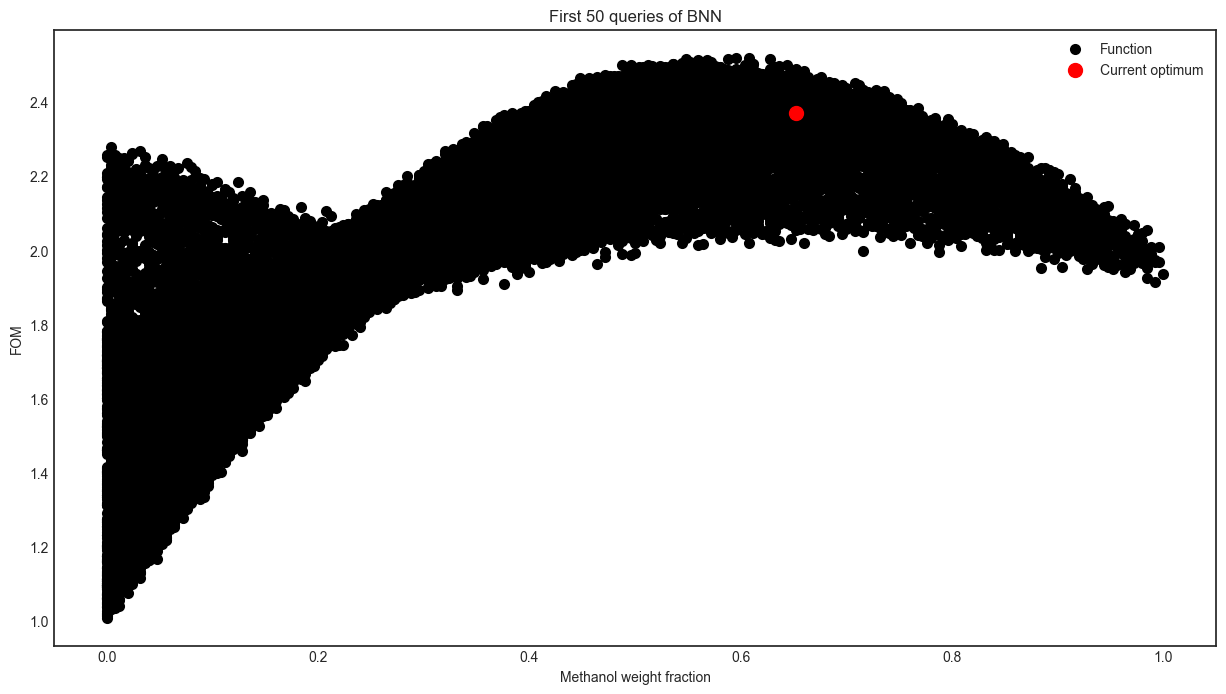

In [19]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(15, 8))
    #plt.scatter(optimizer.X_training[:, 0], optimizer.y_training, c='k', s=50, label='Queried')
    plt.scatter(X[:, 0], y, c='k', linewidth=2, label='Function')
    #plt.fill_between(X[:, 0], y_pred - y_std, y_pred + y_std, alpha=0.5)
    plt.scatter(X_max[0], y_max, s=100, c='r', label='Current optimum')
    plt.title('First {} queries of BNN'.format(n_iterations))
    plt.xlabel('Methanol weight fraction')
    plt.ylabel('FOM')
    plt.legend()
    plt.show()

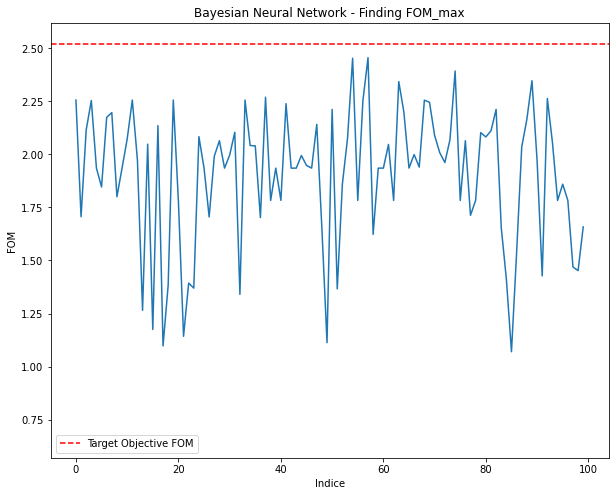

In [311]:
plt.figure(figsize=(10, 8))
plt.plot(FOM_values)
plt.axhline(y=torch.max(y).item(), color='red', linestyle='--', label='Target Objective FOM')
plt.xlabel('Indice')
plt.ylabel('FOM')
plt.ylim([np.min(FOM_values) - 0.5, torch.max(y).item() + 0.1])

plt.title('Bayesian Neural Network - Finding FOM_max')
plt.legend()
plt.show()

In [156]:
y[idx]

tensor(1.0999)